# P3 - Open Food Facts - Nettoyage et Exploration

### Import

In [2]:
import sys
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### Error Management

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
# Les separateurs ne sont pas des comma habituelles, ici il sagit de tabulation. low_memory=False est precise
data = pd.read_csv('../Source/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False, encoding='UTF-8')

### Description du jeu de donnee

In [5]:
data_shape = data.shape
print(f"Le jeu de donnee contient {data_shape[0]} lignes et {data_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 162 colonnes.


### Description variable categorielle

In [6]:
data_lignes = data_shape[0]
desc_var = data.describe(exclude=[np.number])

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [7]:
desc_var

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
nb_nan,23.0,23.0,2.0,3.0,9.0,0.0,0.0,17762.0,267977.0,215953.0,...,99562.0,229259.0,226281.0,46.0,46.0,46.0,236406.0,236406.0,244936.0,244936.0
%_nan,0.00717,0.00717,0.000623,0.000935,0.002806,0.0,0.0,5.537266,83.541269,67.322896,...,31.038245,71.471014,70.542628,0.01434,0.01434,0.01434,73.699076,73.699076,76.358286,76.358286
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,1,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


#### 23 unites de difference entre le nombre de ligne (320772) et le nombre de code (320449)

### Description variable quantitatve

In [8]:
data_lignes = data_shape[0]
desc_var = data.describe()

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [9]:
desc_var

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb_nan,320772.0,71833.0,71833.0,320772.0,71833.0,320772.0,320772.0,59659.0,319915.0,76881.0,...,320723.0,317736.0,320607.0,319824.0,320772.0,320504.0,99562.0,99562.0,320772.0,320772.0
%_nan,100.0,22.393787,22.393787,100.0,22.393787,100.0,100.0,18.598568,99.732832,23.967491,...,99.984724,99.053533,99.948562,99.704463,100.0,99.916452,31.038245,31.038245,100.0,100.0
count,0.0,248939.0,248939.0,0.0,248939.0,0.0,0.0,261113.0,857.0,243891.0,...,49.0,3036.0,165.0,948.0,0.0,268.0,221210.0,221210.0,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1141.914605,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6447.154093,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,8.0,6.0,NaN,0.0,-15.0,-15.0,NaN,NaN
25%,NaN,0.0,0.0,NaN,0.0,NaN,NaN,377.0,49.4,0.0,...,6.3,0.0,12.0,32.0,NaN,98.75,1.0,1.0,NaN,NaN
50%,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1100.0,300.0,5.0,...,7.2,23.0,15.0,50.0,NaN,195.75,10.0,9.0,NaN,NaN
75%,NaN,3.0,0.0,NaN,0.0,NaN,NaN,1674.0,898.0,20.0,...,7.4,51.0,15.0,64.25,NaN,383.2,16.0,16.0,NaN,NaN


#### On remarque que dans plusieurs colonnes _100g, des valeurs supperieurs a 100 sont presentes

In [10]:
data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [13]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [14]:
values = data.dtypes.value_counts()
nb_tot = values.sum()
percentages = round((100 * values / nb_tot), 2)
table = pd.concat([values, percentages], axis=1)
table.columns = ['Nombre par type de variable', '% des types de variable']

In [15]:
table.loc[table['Nombre par type de variable'] != 0].sort_values('% des types de variable', ascending=False).style.background_gradient('seismic')

,Nombre par type de variable,% des types de variable
float64,106,65.430000
object,56,34.570000


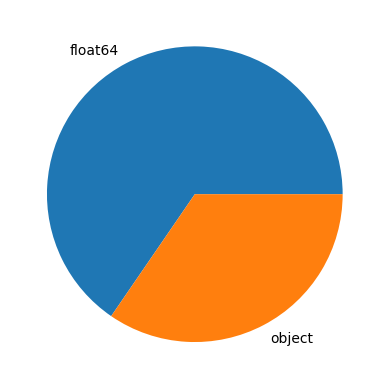

In [16]:
# Pie chart
data.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [17]:
# pourcentage des valeurs manquantes
nan_tot =  data.isna().sum().sum()
data_tot = np.product(data.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :39608589 NaN pour 51965064 données (76.22 %)


#### 76% de valeurs sont manquantes

In [18]:
values = data.isnull().sum()
percentage = 100 * values / len(data)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,320772,100.000000
caproic-acid_100g,320772,100.000000
elaidic-acid_100g,320772,100.000000
nucleotides_100g,320763,100.000000
ingredients_that_may_be_from_palm_oil,320772,100.000000
nutrition_grade_uk,320772,100.000000
serum-proteins_100g,320756,100.000000
maltodextrins_100g,320761,100.000000
maltose_100g,320768,100.000000
nervonic-acid_100g,320772,100.000000


#### De nombreuses valeurs depassent les 80% de valeurs manquantes

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


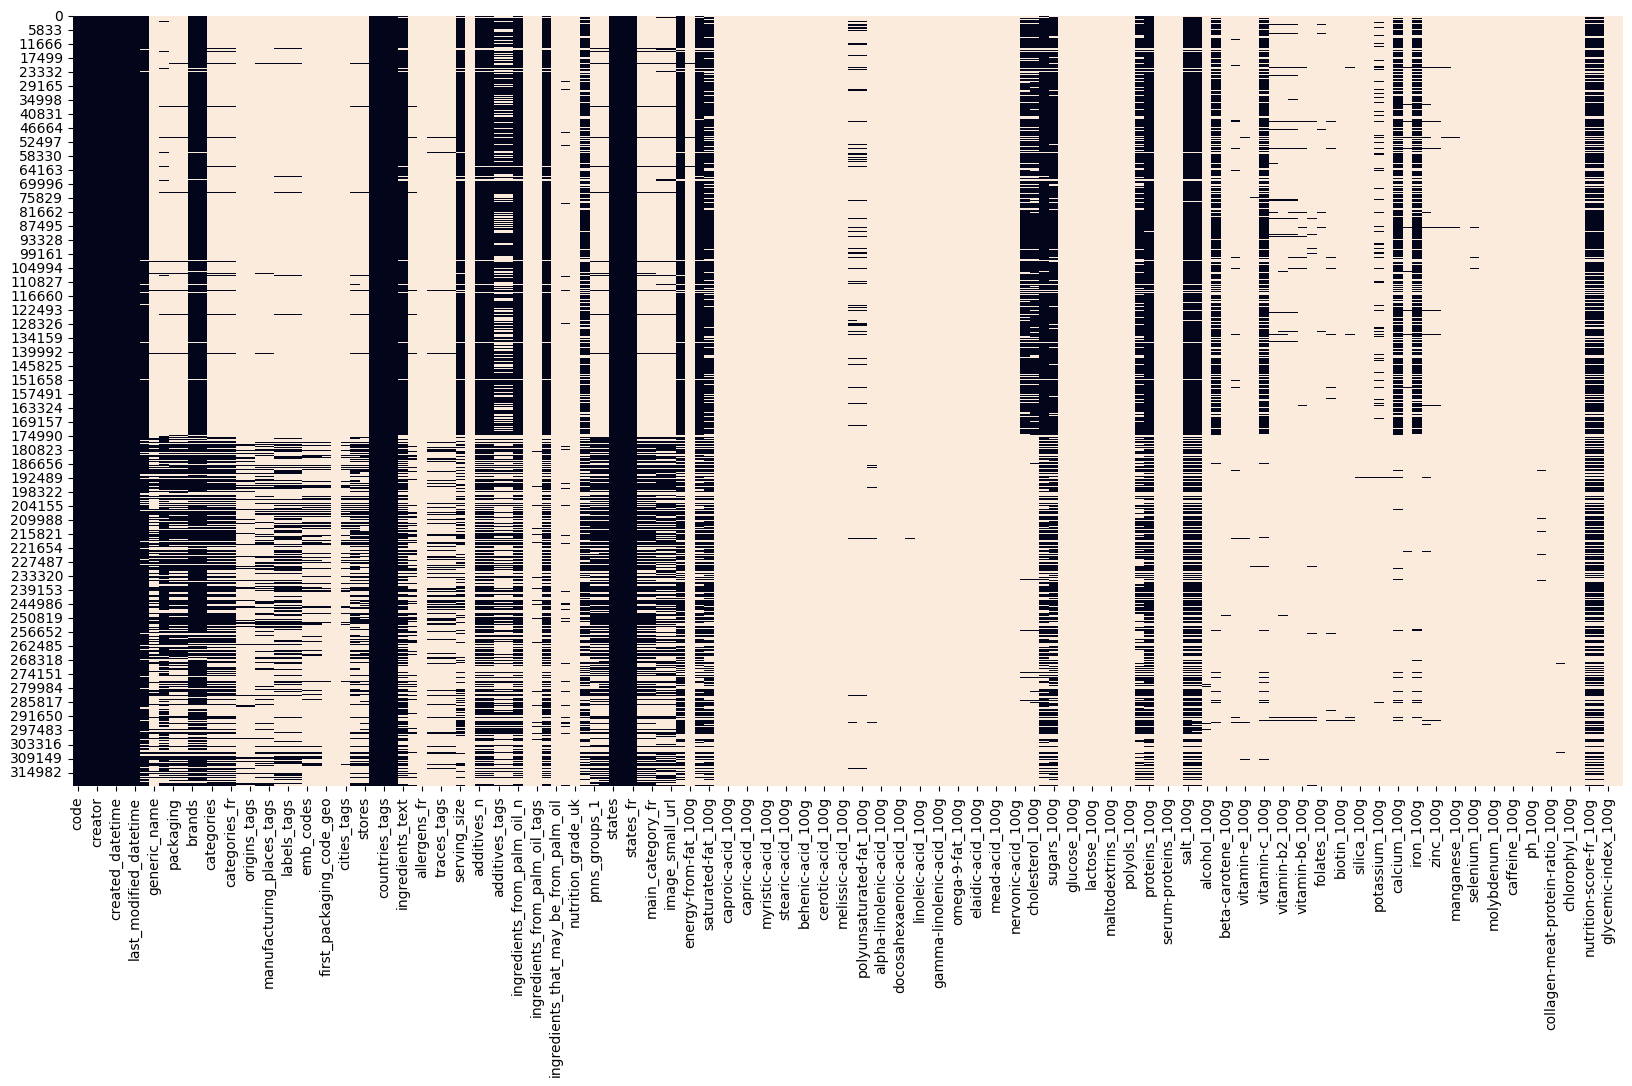

In [19]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data.isna(), cbar=False)
plt.show()

### Nettoyage du jeu de donnees

In [20]:
food = data.copy()

In [21]:
nb_lignes = food.shape[0]
sum_nan = food.isna().sum()

df_nan = pd.DataFrame({'Variable': sum_nan.index,
                           'nb_nan': sum_nan.values})

df_nan['%_nan'] = [(row * 100) / nb_lignes for row in df_nan['nb_nan']]
df_nan['%_nan_groupe'] = pd.cut(df_nan['%_nan'], bins=[0, 10, 20, 40, 60, 80, 100])
sum_gpe_nan = df_nan['%_nan_groupe'].value_counts().sort_index()

df_group_nan = pd.DataFrame({'Plage de %': sum_gpe_nan.index,
                              'nb_variable': sum_gpe_nan.values})



In [22]:
df_nan

,Variable,nb_nan,%_nan,%_nan_groupe
0,code,23,0.007170,"(0, 10]"
1,url,23,0.007170,"(0, 10]"
2,creator,2,0.000623,"(0, 10]"
3,created_t,3,0.000935,"(0, 10]"
4,created_datetime,9,0.002806,"(0, 10]"
...,...,...,...,...
157,carbon-footprint_100g,320504,99.916452,"(80, 100]"
158,nutrition-score-fr_100g,99562,31.038245,"(20, 40]"
159,nutrition-score-uk_100g,99562,31.038245,"(20, 40]"
160,glycemic-index_100g,320772,100.000000,"(80, 100]"


In [23]:
df_group_nan

,Plage de %,nb_variable
0,"(0, 10]",14
1,"(10, 20]",2
2,"(20, 40]",16
3,"(40, 60]",8
4,"(60, 80]",12
5,"(80, 100]",108


#### 108 variables avec plus de 80% de valeurs manquantes.
#### 120 variables avec plus de 60% de valeurs manquantes.
#### Conclusion : la suppression des variables très peu renseignées devra être effectuée.

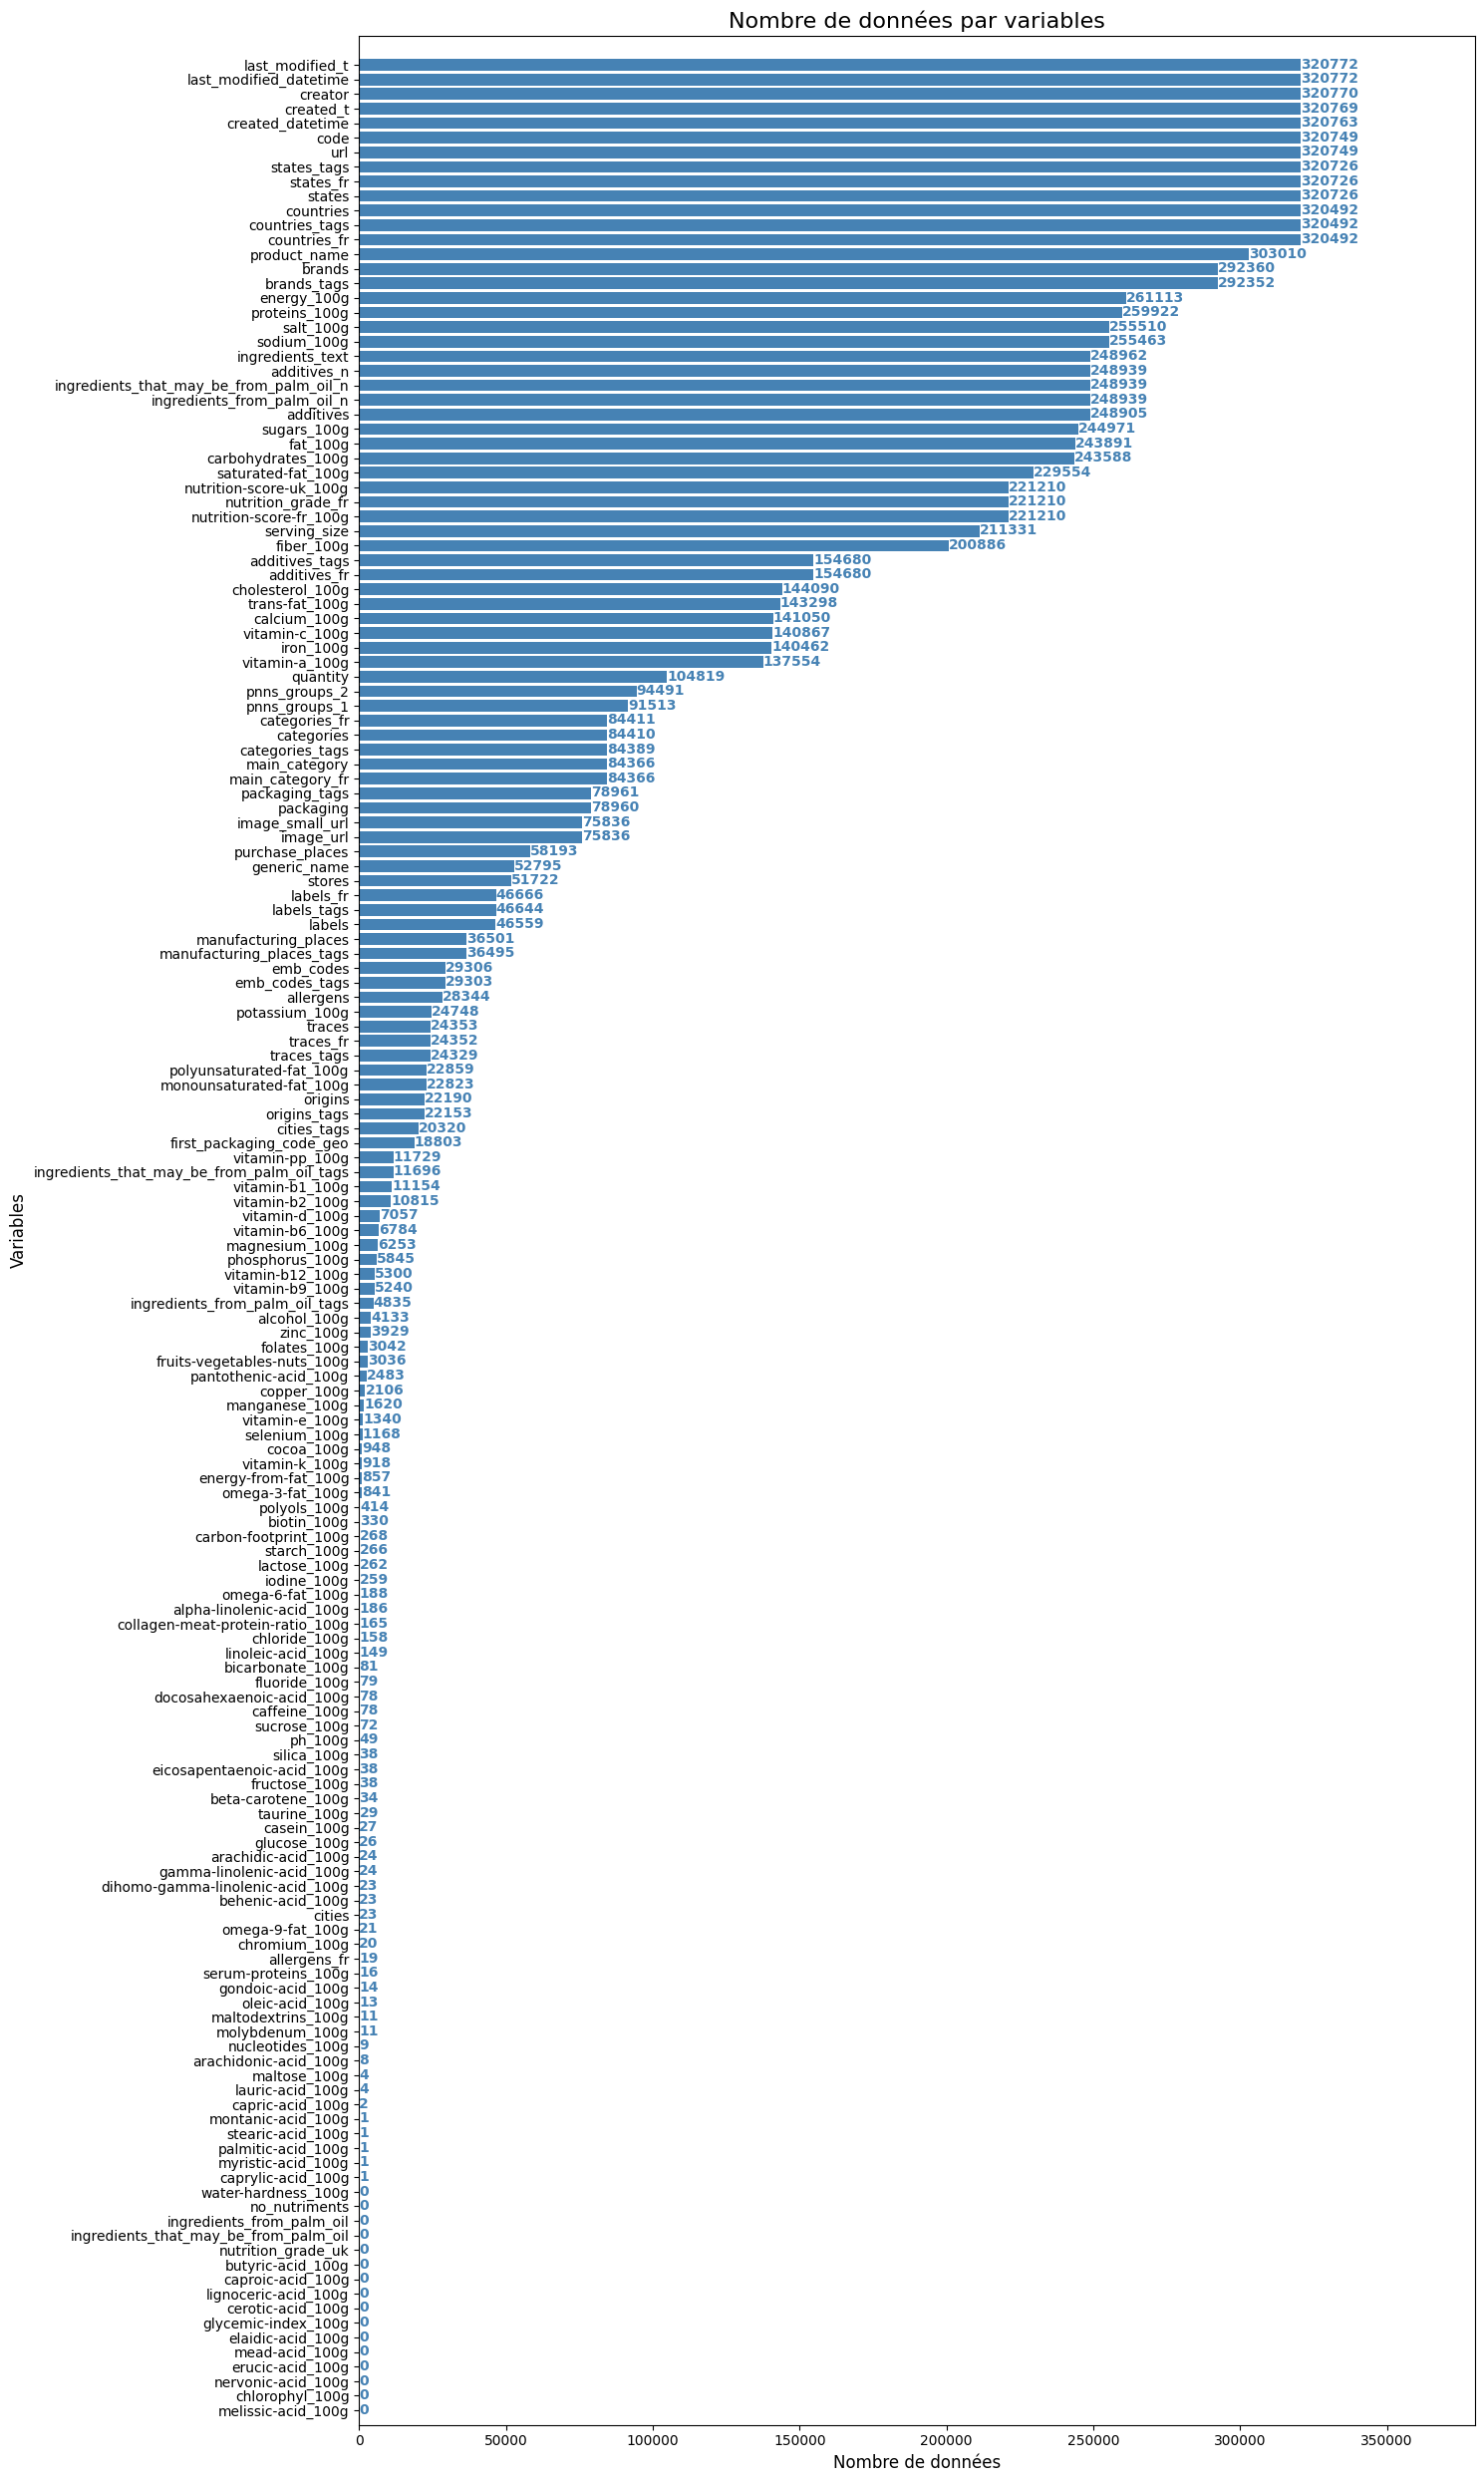

In [24]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 25))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = food.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .25, str(v), color='SteelBlue',
            fontsize=10, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.tick_params(labelsize=10)
ax.set_xlim([0, 380000])
ax.set_ylim([-1, 163])
ax.grid(False)
fig.tight_layout()
plt.show()

### Suppression des varibales completement vides

In [25]:
data_count = food.count()
sum_vide = data_count[data_count == 0]
print(f'Nombre de variables totalements vides : {len(sum_vide)} \n\nListe :')
print(sum_vide.index.tolist())

Nombre de variables totalements vides : 16 

Liste :
['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g', 'elaidic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g']


In [26]:
food.dropna(axis=1, how='all', inplace=True)

In [27]:
food_shape = food.shape
print(f"Le jeu de donnee contient {food_shape[0]} lignes et {food_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 146 colonnes.


#### Modification des noms de variables avec un tiret : '-' -> '_'

In [28]:
car_avant = '-'
car_apres = '_'

cols_a_renommer = food.columns[food.columns.str.contains(car_avant)]
print(f"{len(cols_a_renommer)} variables renommées {car_avant} en {car_apres} : \n\n {cols_a_renommer.tolist()}")

food.columns = food.columns.str.replace(car_avant, car_apres)

45 variables renommées - en _ : 

 ['energy-from-fat_100g', 'saturated-fat_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'montanic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'gondoic-acid_100g', 'trans-fat_100g', 'serum-proteins_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'pantothenic-acid_100g', 'fruits-vegetables-nuts_100g', 'collagen-meat-protein-ratio_100g', 'carbon-f

In [29]:
food.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',


### Filtrer les donnees pertinentes

#### parametres qu'on souhaite conserver : nutriscore / proteines / lipides / glucides / vitamines / mineraux / produits FR / produits peu transformes / noms produits / categories / marques 

In [30]:
# Information generales, comparaison des colonnes generic_name vs product_name

data_product = food.loc[food['generic_name'] != food['product_name']]
data_product = data_product[['generic_name', 'product_name']][data_product['generic_name'].notnull()]
data_product

,generic_name,product_name
174,Laitue en salade,Salade Cesar
175,Pâtisserie,Danoises à la cannelle roulées
180,Pâtisserie,Chaussons tressés aux pommes
181,Pain,Pain Burger Artisan
184,Biscuits sablés déclassés fourrage au cacao,Biscuits sablés fourrage au cacao
...,...,...
320758,Miel,Miel de Camargue
320761,Vins blanc du Bugey,Roussette du Bugey (2011)
320762,Sprot,Szprot w oleju roslinnym
320763,thé bio équitable,Thé vert Earl grey


#### La variable product_name contient plus d'informations non null que la colonne generic_name, conservation de product_name

In [31]:
# comparaison des colonnes countries vs countries_fr vs countries_tags

condt_countries = food['countries'] != food['countries_fr']
condt_countries2 = food['countries'] != food['countries_tags']

data_countries = food.loc[condt_countries | condt_countries2]
data_countries = data_countries[['countries', 'countries_fr', 'countries_tags']]
data_countries

,countries,countries_fr,countries_tags
0,en:FR,France,en:france
1,US,États-Unis,en:united-states
2,US,États-Unis,en:united-states
3,US,États-Unis,en:united-states
4,US,États-Unis,en:united-states
...,...,...,...
320767,en:RO,Roumanie,en:romania
320768,US,États-Unis,en:united-states
320769,China,Chine,en:china
320770,en:FR,France,en:france


#### La variable countries_fr contient tous les pays et pas seulement la France, conservation de cette colonne

In [32]:
# comparaison des colonnes pnns_groups_1 vs pnns_groups_2

data_gpe_product = food.loc[food['pnns_groups_1'] != food['pnns_groups_2']]
data_gpe_product = data_gpe_product[['pnns_groups_1', 'pnns_groups_2']]
data_gpe_product

,pnns_groups_1,pnns_groups_2
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
320767,NaN,NaN
320768,NaN,NaN
320769,Salty snacks,Appetizers
320770,NaN,NaN


In [33]:
print(data_gpe_product[data_gpe_product.notnull().all(axis=1)])

                pnns_groups_1          pnns_groups_2
174     Fruits and vegetables             Vegetables
175             Sugary snacks     Biscuits and cakes
177      Cereals and potatoes                  Bread
180             Sugary snacks     Biscuits and cakes
182      Cereals and potatoes                Legumes
...                       ...                    ...
320759  Fruits and vegetables                 Fruits
320763              Beverages  Non-sugared beverages
320765         Fish Meat Eggs         Processed meat
320766           Salty snacks                   Nuts
320769           Salty snacks             Appetizers

[68889 rows x 2 columns]


#### pnns_1 represente un groupe et pnns_2 un sous groupe, conservation des 2 parametres

In [34]:
# comparaison des colonnes brands vs brands_tags

data_brnds = food.loc[food['brands'] != food['brands_tags']]
data_brnds = data_brnds[['brands', 'brands_tags']][data_brnds['brands'].notnull()]
data_brnds

,brands,brands_tags
0,Ferme t'y R'nao,ferme-t-y-r-nao
2,Torn & Glasser,torn-glasser
3,Grizzlies,grizzlies
4,Bob's Red Mill,bob-s-red-mill
5,Unfi,unfi
...,...,...
320765,"Sans marque,D.Lambert","sans-marque,d-lambert"
320767,Panzani,panzani
320768,Trader Joe's,trader-joe-s
320770,Knorr,knorr


#### Le nom de la marque est plus littéraire dans la variable 'brands', conservation de la colonne brands

### Variables retenues : code / image_url / product_name / stores / countries_fr / pnns_groups_1 / pnns_groups_2 / brands

In [35]:
cols_info_gen = ['code', 'image_url', 'product_name', 'stores', 'countries_fr', 'pnns_groups_1', 'pnns_groups_2', 'brands']

### Variables Alimentaires

In [36]:
cols_nutriments = food.columns[food.columns.str.endswith('_100g')]
cols_nutriments = cols_nutriments.to_list()
cols_nutriments

['energy_100g',
 'energy_from_fat_100g',
 'fat_100g',
 'saturated_fat_100g',
 'caprylic_acid_100g',
 'capric_acid_100g',
 'lauric_acid_100g',
 'myristic_acid_100g',
 'palmitic_acid_100g',
 'stearic_acid_100g',
 'arachidic_acid_100g',
 'behenic_acid_100g',
 'montanic_acid_100g',
 'monounsaturated_fat_100g',
 'polyunsaturated_fat_100g',
 'omega_3_fat_100g',
 'alpha_linolenic_acid_100g',
 'eicosapentaenoic_acid_100g',
 'docosahexaenoic_acid_100g',
 'omega_6_fat_100g',
 'linoleic_acid_100g',
 'arachidonic_acid_100g',
 'gamma_linolenic_acid_100g',
 'dihomo_gamma_linolenic_acid_100g',
 'omega_9_fat_100g',
 'oleic_acid_100g',
 'gondoic_acid_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum_proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alco

In [37]:
# comparaison colonnes nutrition_score_fr_100g vs nutrition_score_uk_100g

data_nutrition_scrore = food.loc[food['nutrition_score_fr_100g'] != food['nutrition_score_uk_100g']]
data_nutrition_scrore = data_nutrition_scrore[['nutrition_score_fr_100g', 'nutrition_score_uk_100g']]
data_nutrition_scrore

,nutrition_score_fr_100g,nutrition_score_uk_100g
0,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
8,NaN,NaN
...,...,...
320766,NaN,NaN
320767,NaN,NaN
320769,NaN,NaN
320770,NaN,NaN


In [38]:
print(data_nutrition_scrore[data_nutrition_scrore.notnull().all(axis=1)])

        nutrition_score_fr_100g  nutrition_score_uk_100g
226                        13.0                      2.0
240                        13.0                      2.0
648                        11.0                     20.0
664                        12.0                      1.0
695                        14.0                     19.0
...                         ...                      ...
320626                     13.0                      2.0
320629                     14.0                      0.0
320656                     16.0                     20.0
320668                      4.0                     -3.0
320763                      2.0                      0.0

[8322 rows x 2 columns]


#### Peu d'informations presentes. les valeurs nutriscore ne correpondent pas suivant le pays, conservation des deux colonnes

In [39]:
# comparaison colonnes additives

condt_additives = food['additives'] != food['additives_fr']
condt_additives2 = food['additives'] != food['additives_tags']

data_additives = food.loc[condt_additives | condt_additives2]
data_additives = data_additives[['additives', 'additives_fr', 'additives_tags']][data_additives['additives_fr'].notnull()]
data_additives

,additives,additives_fr,additives_tags
7,[ org-oats -> en:org-oats ] [ oats -> en:oa...,"E123 - Amarante,E307a - Tocophérol","en:e123,en:e307a"
12,[ roasted-peanuts -> en:roasted-peanuts ] [...,E100 - Curcumine,en:e100
21,[ chocolate-stars -> en:chocolate-stars ] [...,E322 - Lécithines,en:e322
23,[ dry-roasted-almonds -> en:dry-roasted-almon...,"E339iii - Phosphate de sodium tribasique,E330 ...","en:e339iii,en:e330"
24,[ peanut-butter -> en:peanut-butter ] [ but...,"E170 - Carbonate de calcium,E322 - Lécithines,...","en:e170,en:e322,en:e410"
...,...,...,...
320708,[ purified-water -> en:purified-water ] [ w...,"E500ii - Hydrogénocarbonate de sodium,E333 - C...","en:e500ii,en:e333,en:e508,en:e530"
320730,[ organic-wheat-flour -> en:organic-wheat-flo...,"E422 - Glycérol,E330 - Acide citrique,E296 - A...","en:e422,en:e330,en:e296"
320738,[ organic-oat-blend -> en:organic-oat-blend ...,E322 - Lécithines,en:e322
320750,[ water -> en:water ] [ high-fructose-corn-...,"E330 - Acide citrique,E440 - Pectines,E331 - C...","en:e330,en:e440,en:e331,en:e150a,en:e201,en:e1..."


#### on retrouve tous les additifs alimentaire. la colonnes 'additives_fr' semble plus adaptes, conservation de cette colonne.

### Variables Alimentations Saines

In [40]:
cols_alim_saine = ['additives_n', 'additives_fr', 'ingredients_from_palm_oil_n',
                   'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n',
                   'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr', 'allergens']

In [41]:
cols_a_garder = cols_info_gen + cols_nutriments + cols_alim_saine
cols_a_garder

['code',
 'image_url',
 'product_name',
 'stores',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'energy_from_fat_100g',
 'fat_100g',
 'saturated_fat_100g',
 'caprylic_acid_100g',
 'capric_acid_100g',
 'lauric_acid_100g',
 'myristic_acid_100g',
 'palmitic_acid_100g',
 'stearic_acid_100g',
 'arachidic_acid_100g',
 'behenic_acid_100g',
 'montanic_acid_100g',
 'monounsaturated_fat_100g',
 'polyunsaturated_fat_100g',
 'omega_3_fat_100g',
 'alpha_linolenic_acid_100g',
 'eicosapentaenoic_acid_100g',
 'docosahexaenoic_acid_100g',
 'omega_6_fat_100g',
 'linoleic_acid_100g',
 'arachidonic_acid_100g',
 'gamma_linolenic_acid_100g',
 'dihomo_gamma_linolenic_acid_100g',
 'omega_9_fat_100g',
 'oleic_acid_100g',
 'gondoic_acid_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',


In [42]:
data_retained = food[cols_a_garder]

In [43]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 103 colonnes.


## Visualisation des valeurs manquantes

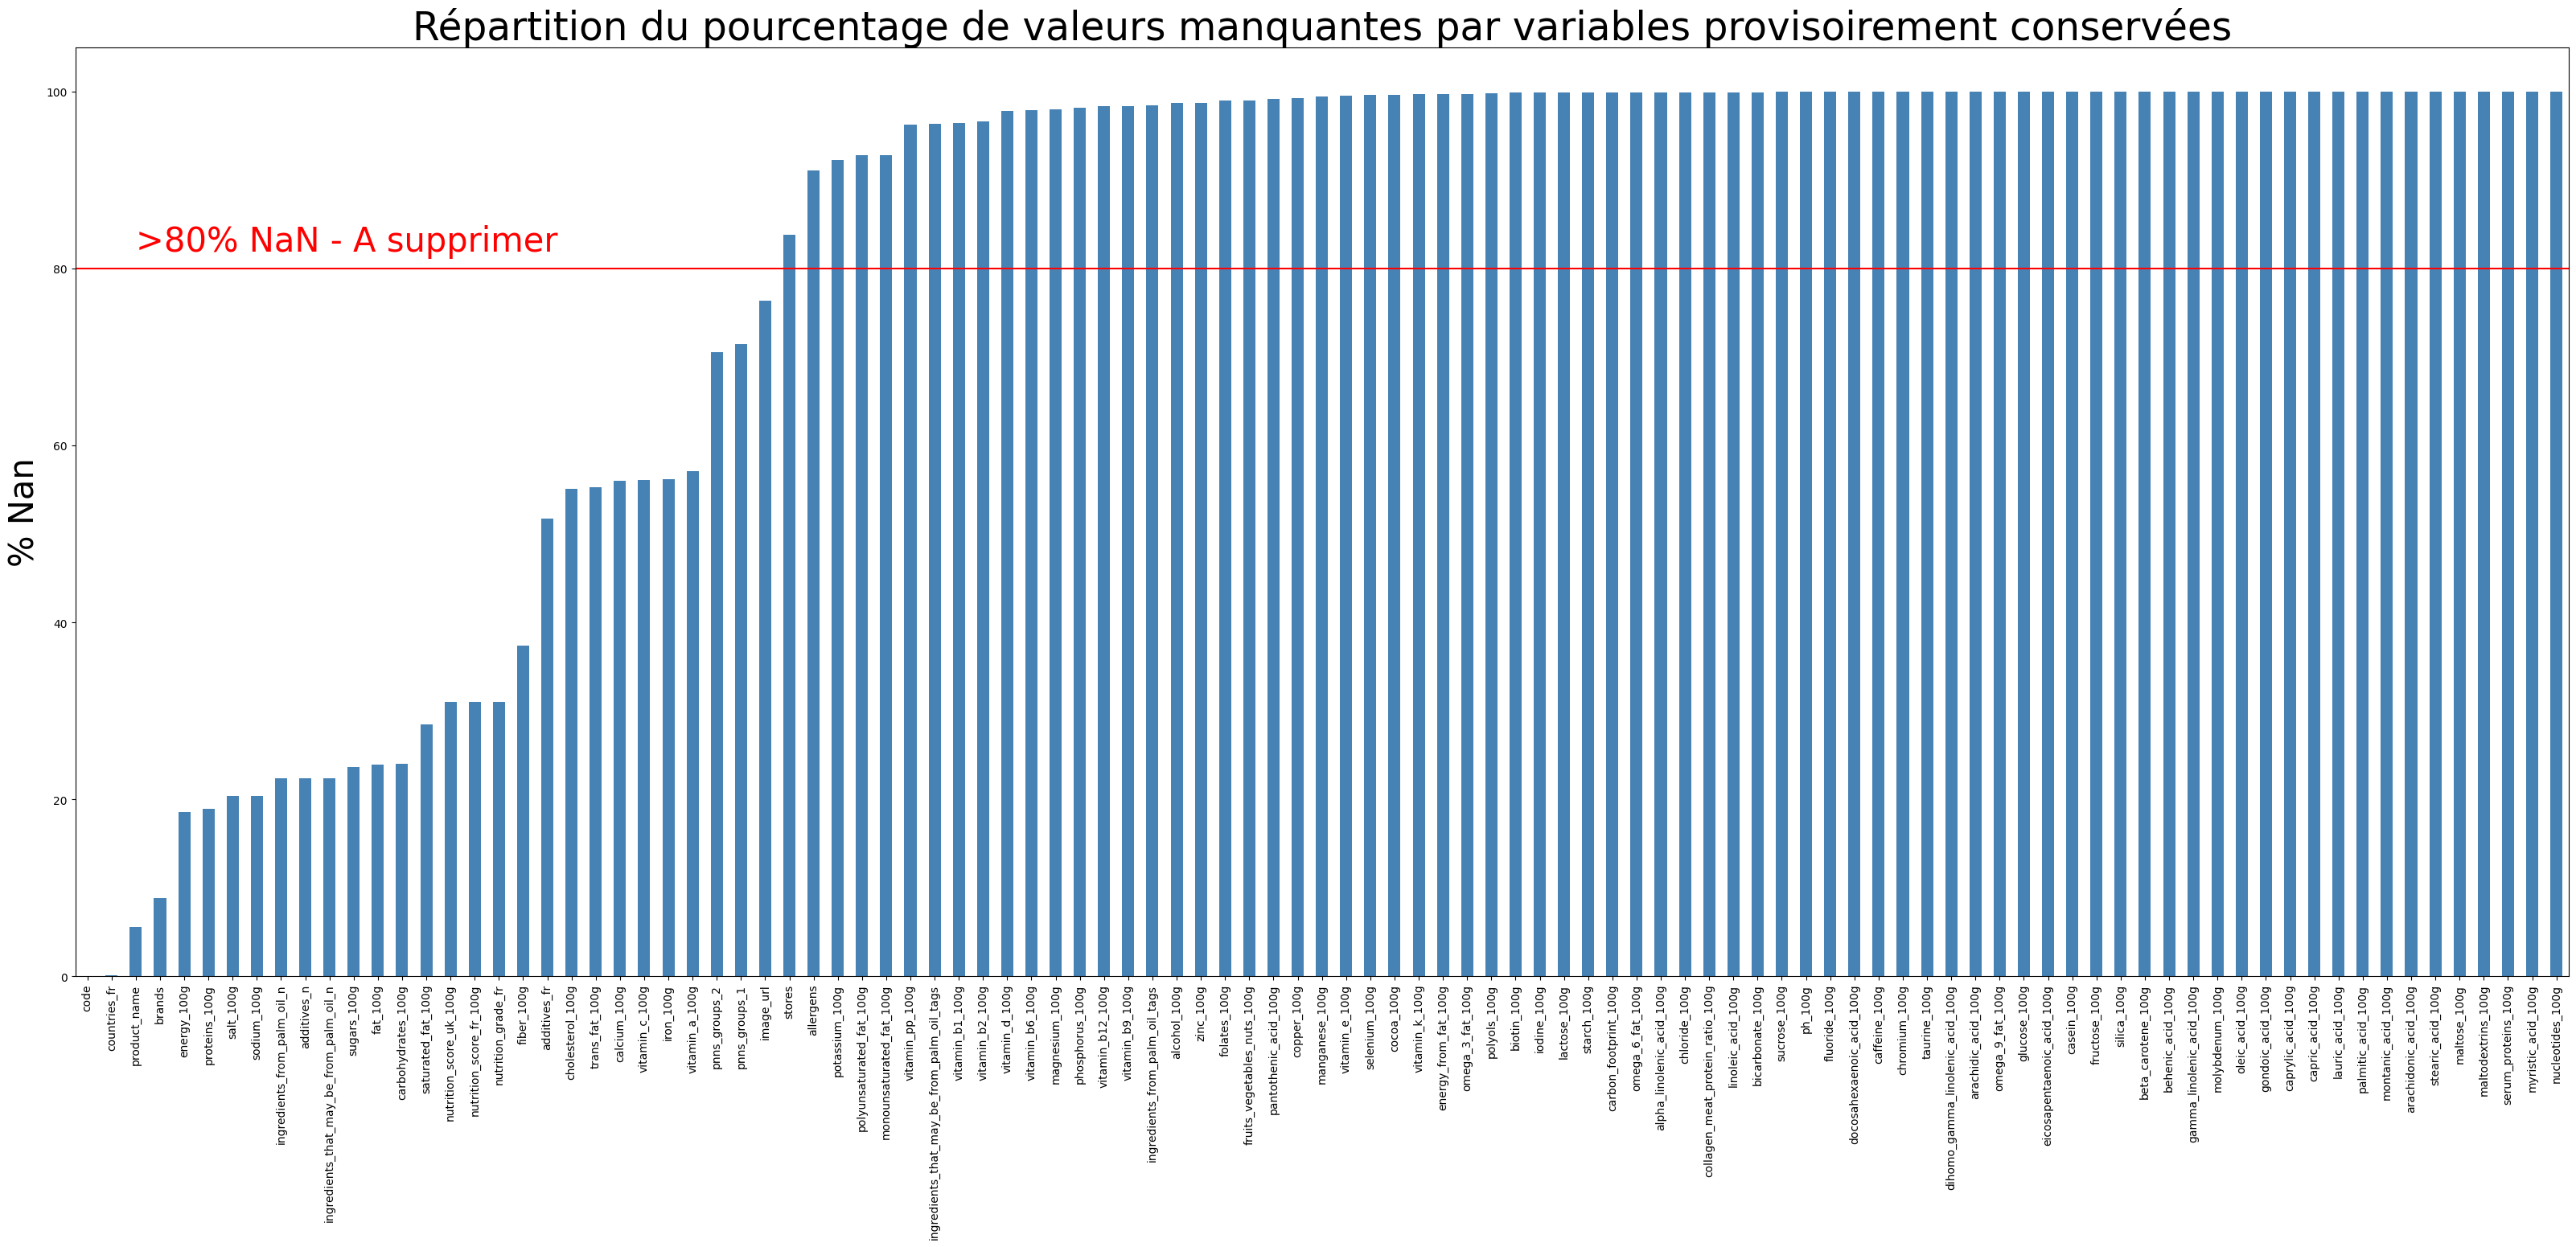

In [44]:
# Répartition du pourcentage de valeurs manquantes pour toutes les variables provisoirement conservées
plt.figure(figsize=(40, 15))
data_retained_nan = round((data_retained.isna().sum()/data_retained.shape[0]) * 100, 2)
data_retained_nan.sort_values(inplace=True)
data_retained_nan.plot(kind='bar', color='SteelBlue')
plt.title('Répartition du pourcentage de valeurs manquantes par variables provisoirement conservées', fontsize=35)
plt.ylabel('% Nan', fontsize=30)
plt.axhline(y=80, color='r')
plt.text(2, 82, '>80% NaN - A supprimer', color='r', fontsize=30)
plt.show()

## Constitution du jeu de donnees de travail

In [45]:
data_work_nan = round((data_retained.isna().sum() / data_retained.shape[0]) * 100, 2)
cols = data_retained.columns.tolist()

# Conservation seulement des variables avec valeurs manquantes >= 80%
seuil = 80
cols_a_garder = data_work_nan[data_work_nan.values < seuil].index.tolist()

cols_info_gen_supprimees = [col for col in cols if col not in cols_a_garder]

data_retained = data_retained[cols_a_garder]

print(f'Liste des variables éliminées :\n{cols_info_gen_supprimees}\n')
print(f'Liste des variables conservées :\n{cols_a_garder}')

Liste des variables éliminées :
['stores', 'energy_from_fat_100g', 'caprylic_acid_100g', 'capric_acid_100g', 'lauric_acid_100g', 'myristic_acid_100g', 'palmitic_acid_100g', 'stearic_acid_100g', 'arachidic_acid_100g', 'behenic_acid_100g', 'montanic_acid_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'omega_3_fat_100g', 'alpha_linolenic_acid_100g', 'eicosapentaenoic_acid_100g', 'docosahexaenoic_acid_100g', 'omega_6_fat_100g', 'linoleic_acid_100g', 'arachidonic_acid_100g', 'gamma_linolenic_acid_100g', 'dihomo_gamma_linolenic_acid_100g', 'omega_9_fat_100g', 'oleic_acid_100g', 'gondoic_acid_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g', 'lactose_100g', 'maltose_100g', 'maltodextrins_100g', 'starch_100g', 'polyols_100g', 'casein_100g', 'serum_proteins_100g', 'nucleotides_100g', 'alcohol_100g', 'beta_carotene_100g', 'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g', 'vitamin_b9_100g', 'fola

In [46]:
data_retained.shape

(320772, 29)

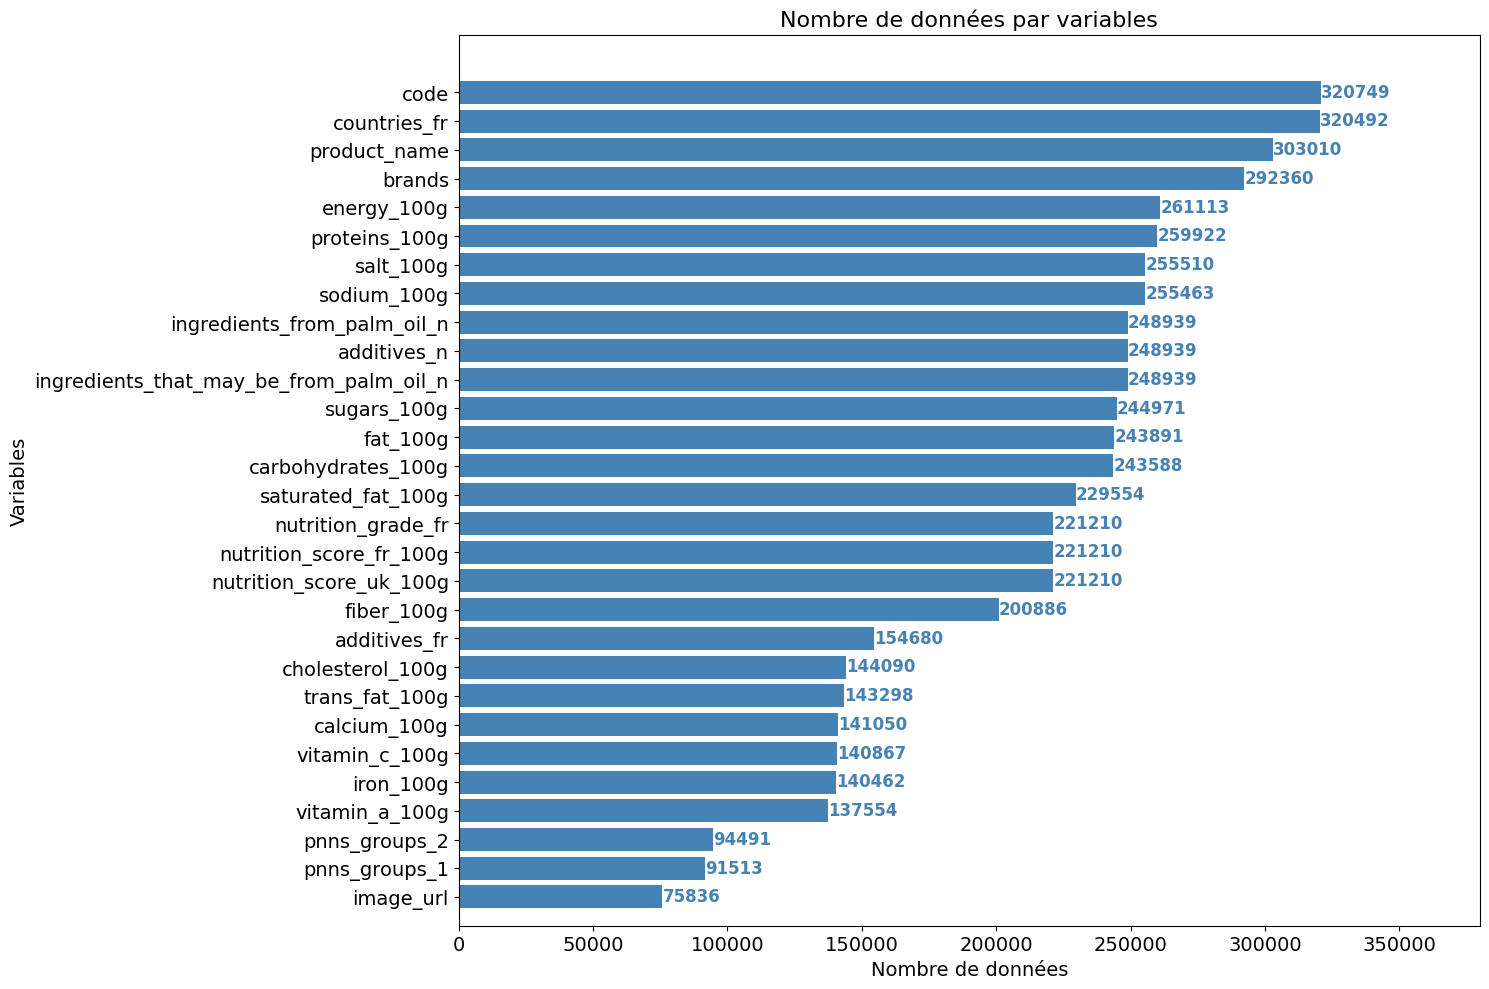

In [47]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 10))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = data_retained.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .15, str(v), color='SteelBlue',
            fontsize=12, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=14)
ax.set_ylabel('Variables', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim([0, 380000])
ax.set_ylim([-1, 30])
ax.grid(False)

fig.tight_layout()
plt.show()

### Modification des types de variables

In [48]:
data_retained.dtypes

code                                        object
image_url                                   object
product_name                                object
countries_fr                                object
pnns_groups_1                               object
pnns_groups_2                               object
brands                                      object
energy_100g                                float64
fat_100g                                   float64
saturated_fat_100g                         float64
trans_fat_100g                             float64
cholesterol_100g                           float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                                float64
vitamin_a_100g                             float64
vitamin_c_100g                 

#### transformation des types object en category si le nombre ede modalite est inf au nombre de ligne

In [49]:
for col in data_retained.columns.values:
    if data_retained[col].dtype == 'object':
        #print(data_retained[col].unique())
        print('Colonne : ', col)
        if len(data_retained[col].unique()) / len(data_retained[col]) < 0.5:
            data_retained[col] = data_retained[col].astype('category')

Colonne :  code
Colonne :  image_url
Colonne :  product_name
Colonne :  countries_fr
Colonne :  pnns_groups_1
Colonne :  pnns_groups_2
Colonne :  brands
Colonne :  additives_fr
Colonne :  nutrition_grade_fr


In [50]:
data_retained.dtypes

code                                         object
image_url                                  category
product_name                                 object
countries_fr                               category
pnns_groups_1                              category
pnns_groups_2                              category
brands                                     category
energy_100g                                 float64
fat_100g                                    float64
saturated_fat_100g                          float64
trans_fat_100g                              float64
cholesterol_100g                            float64
carbohydrates_100g                          float64
sugars_100g                                 float64
fiber_100g                                  float64
proteins_100g                               float64
salt_100g                                   float64
sodium_100g                                 float64
vitamin_a_100g                              float64
vitamin_c_10

### Suppression des produits sans noms

In [51]:
data_retained.dropna(subset=['product_name'], inplace=True)

In [52]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 303010 lignes et 29 colonnes.


### Conservation des produits FR uniquement

In [53]:
data_retained.loc[data_retained['countries_fr'] == 'France', :]

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
0,0000000003087,NaN,Farine de blé noir,France,NaN,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,http://fr.openfoodfacts.org/images/products/00...,Filet de bœuf,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,http://fr.openfoodfacts.org/images/products/00...,Twix x2,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,http://fr.openfoodfacts.org/images/products/00...,lentilles vertes,France,Cereals and potatoes,Legumes,Bertrand Lejeune,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
184,0000007730009,http://fr.openfoodfacts.org/images/products/00...,Biscuits sablés fourrage au cacao,France,Sugary snacks,Biscuits and cakes,St Michel,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,"E1400 - Dextrines,E322 - Lécithines,E503 - Car...",0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,http://fr.openfoodfacts.org/images/products/99...,Roussette du Bugey (2011),France,NaN,Alcoholic beverages,Roussette du Bugey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,http://fr.openfoodfacts.org/images/products/99...,Thé vert Earl grey,France,Beverages,Non-sugared beverages,Lobodis,21.0,0.2,0.2,...,NaN,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0,c
320764,9918,http://fr.openfoodfacts.org/images/products/99...,"Cheese cake thé vert, yuzu",France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,http://fr.openfoodfacts.org/images/products/99...,Rillette d'oie,France,Fish Meat Eggs,Processed meat,"Sans marque,D.Lambert",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [54]:
data_retained.countries_fr.unique().to_list()

['France',
 'États-Unis',
 'Royaume-Uni',
 'France,États-Unis',
 'Canada',
 'Suisse',
 'Espagne',
 'Allemagne',
 'Slovénie',
 'Italie',
 'Roumanie',
 'Australie',
 'France,Royaume-Uni',
 'Belgique,France,Pays-Bas,Royaume-Uni',
 'Guadeloupe',
 'Royaume-Uni,États-Unis',
 'Canada,États-Unis',
 'Pays-Bas',
 'Australie,France',
 'Canada,France,Suisse,États-Unis',
 'France,États-Unis,en:Etats-unis',
 'Irlande',
 'France,La Réunion',
 'Australie,Suisse',
 'France,Allemagne',
 'Brésil',
 'Belgique,France',
 'États-Unis,en:Australie',
 'Arabie saoudite',
 'Émirats arabes unis',
 'Moldavie',
 'Belgique',
 nan,
 'Singapour',
 'Finlande',
 'Australie,États-Unis',
 'France,Suisse',
 'Australie,Nouvelle-Zélande,Singapour,Thaïlande,États-Unis',
 'Panama',
 'Costa Rica',
 'États-Unis,en:Pays-bas',
 'Espagne,Royaume-Uni,en:Scotland',
 'Thaïlande',
 'Mexique',
 'Chine',
 'Luxembourg',
 'Liban',
 'Suisse,États-Unis',
 'États-Unis,en:Deutschland',
 'France,Suisse,États-Unis',
 'Belgique,Suisse,États-Unis'

In [55]:
data_retained = data_retained.loc[data_retained['countries_fr'] == 'France']

In [56]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 87398 lignes et 29 colonnes.


In [57]:
data_retained

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
0,0000000003087,NaN,Farine de blé noir,France,NaN,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,http://fr.openfoodfacts.org/images/products/00...,Filet de bœuf,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,http://fr.openfoodfacts.org/images/products/00...,Twix x2,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,http://fr.openfoodfacts.org/images/products/00...,lentilles vertes,France,Cereals and potatoes,Legumes,Bertrand Lejeune,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
184,0000007730009,http://fr.openfoodfacts.org/images/products/00...,Biscuits sablés fourrage au cacao,France,Sugary snacks,Biscuits and cakes,St Michel,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,"E1400 - Dextrines,E322 - Lécithines,E503 - Car...",0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,http://fr.openfoodfacts.org/images/products/99...,Roussette du Bugey (2011),France,NaN,Alcoholic beverages,Roussette du Bugey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,http://fr.openfoodfacts.org/images/products/99...,Thé vert Earl grey,France,Beverages,Non-sugared beverages,Lobodis,21.0,0.2,0.2,...,NaN,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0,c
320764,9918,http://fr.openfoodfacts.org/images/products/99...,"Cheese cake thé vert, yuzu",France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,http://fr.openfoodfacts.org/images/products/99...,Rillette d'oie,France,Fish Meat Eggs,Processed meat,"Sans marque,D.Lambert",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


### Groupe de produit

In [58]:
# Remplacement des tirets '-' par un esapce simple
data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].str.replace('-', " ")

In [59]:
# Normaliser tout en minuscule
data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].str.lower().apply(str)

In [60]:
data_retained['pnns_groups_1'].sort_values().unique().tolist()

['beverages',
 'cereals and potatoes',
 'composite foods',
 'fat and sauces',
 'fish meat eggs',
 'fruits and vegetables',
 'milk and dairy products',
 'nan',
 'salty snacks',
 'sugary snacks',
 'unknown']

In [61]:
# Traduction de certains nom de groupe en Francais
dico_trad_grp1 = {'beverages': 'boissons',
                  'cereals and potatoes': 'cereales et pommes de terre',
                  'composite foods': 'aliments composes',
                  'fat and sauces': 'matieres grasses et les sauces',
                  'fish meat eggs': 'poisson viande oeufs',
                  'fruits and vegetables': 'fruits et legumes',
                  'milk and dairy products': 'lait et les produits laitiers',
                  'nan': 'a renseigner',
                  'salty snacks': 'collation sales',
                  'sugary snacks': 'collation sucree',
                  'unknown': 'a renseigner'}

for cle, valeur in dico_trad_grp1.items():
    data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].replace(cle, valeur)

In [62]:
data_retained['pnns_groups_1'].sort_values().unique().tolist()

['a renseigner',
 'aliments composes',
 'boissons',
 'cereales et pommes de terre',
 'collation sales',
 'collation sucree',
 'fruits et legumes',
 'lait et les produits laitiers',
 'matieres grasses et les sauces',
 'poisson viande oeufs']

In [63]:
# Meme chose pour le sous groupe de produit pnns_groups_2
data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].str.replace('-', " ")

In [64]:
data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].str.lower().apply(str)

In [65]:
data_retained['pnns_groups_2'].sort_values().unique().tolist()

['alcoholic beverages',
 'appetizers',
 'artificially sweetened beverages',
 'biscuits and cakes',
 'bread',
 'breakfast cereals',
 'cereals',
 'cheese',
 'chocolate products',
 'dairy desserts',
 'dressings and sauces',
 'dried fruits',
 'eggs',
 'fats',
 'fish and seafood',
 'fruit juices',
 'fruit nectars',
 'fruits',
 'ice cream',
 'legumes',
 'meat',
 'milk and yogurt',
 'nan',
 'non sugared beverages',
 'nuts',
 'one dish meals',
 'pastries',
 'pizza pies and quiche',
 'potatoes',
 'processed meat',
 'salty and fatty products',
 'sandwich',
 'soups',
 'sweetened beverages',
 'sweets',
 'tripe dishes',
 'unknown',
 'vegetables']

In [69]:
dico_trad_grp2 = {'alcoholic beverages': 'boissons alcoolisees',
                  'appetizers': 'aperitifs',
                  'artificially sweetened beverages': 'boissons sucrees artificiellement',
                  'biscuits and cakes': 'biscuits et gateaux',
                  'bread': 'pain',
                  'breakfast cereals': 'cereales pour le petit dejeuner',
                  'cereals': 'cereales',
                  'cheese': 'fromage',
                  'chocolate products': 'produits a base de chocolat',
                  'dairy desserts': 'desserts laitiers',
                  'dressings and sauces': 'vinaigrettes et sauces',
                  'dried fruits': 'fruits secs',
                  'eggs': 'oeufs',
                  'fats': 'matieres grasses',
                  'fish and seafood': 'poissons et fruits de mer',
                  'fruit juices': 'jus de fruits',
                  'fruit nectars': 'nectars de fruits',
                  'ice cream': 'glaces',
                  'legumes': 'legumineuses',
                  'meat': 'viande',
                  'milk and yogurt': 'lait et yaourt',
                  'nan': 'a renseigner',
                  'nuts': 'noix',
                  'offals': 'abats',
                  'one-dish meals': 'repas a un plat',
                  'pastries': 'patisseries',
                  'pizza pies and quiches': 'pizzas et quiches',
                  'plant-based milk substitutes': 'substituts de lait a base de plantes',
                  'potatoes': 'pommes de terre',
                  'processed meat': 'viande transformee',
                  'salty and fatty products': 'produits sales et gras',
                  'sandwiches': 'sandwiches',
                  'soups': 'soupes',
                  'sweetened beverages': 'boissons sucrees',
                  'sweets': 'sucreries',
                  'teas and herbal teas and coffees': 'thes tisanes cafes',
                  'unsweetened beverages': 'boissons non sucrees',
                  'vegetables': 'legumes',
                  'waters and flavored waters': 'eaux et eaux aromatisees',
                  'unknown': 'a renseigner'}

for cle, val in dico_trad_grp2.items():
    data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].replace(cle, val)

In [70]:
data_retained['pnns_groups_2'].sort_values().unique().tolist()

['a renseigner',
 'aperitifs',
 'biscuits et gateaux',
 'boissons alcoolisees',
 'boissons sucrees',
 'boissons sucrees artificiellement',
 'cereales',
 'cereales pour le petit dejeuner',
 'desserts laitiers',
 'fromage',
 'fruits',
 'fruits secs',
 'glaces',
 'jus de fruits',
 'lait et yaourt',
 'legumineuses',
 'matieres grasses',
 'nectars de fruits',
 'noix',
 'non sugared beverages',
 'oeufs',
 'one dish meals',
 'pain',
 'patisseries',
 'pizza pies and quiche',
 'poissons et fruits de mer',
 'pommes de terre',
 'produits a base de chocolat',
 'produits sales et gras',
 'sandwich',
 'soupes',
 'sucreries',
 'tripe dishes',
 'viande',
 'viande transformee',
 'vinaigrettes et sauces']

### Valeurs aberrantes

In [71]:
# Info generales
data_taille = data_retained.shape[0]
desc_var = data_retained.describe(include='all')

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_taille - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_taille
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                        index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])
desc_var

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
type,object,object,object,object,object,object,object,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,object,float64,float64,object
nb_nan,0.0,40324.0,0.0,0.0,0.0,0.0,5727.0,26280.0,43102.0,28309.0,...,86318.0,85496.0,86486.0,29194.0,29194.0,36958.0,58771.0,36958.0,36958.0,29194.0
%_nan,0.0,46.138356,0.0,0.0,0.0,0.0,6.552782,30.069338,49.316918,32.390901,...,98.764274,97.823749,98.956498,33.40351,33.40351,42.287009,67.245246,42.287009,42.287009,33.40351
count,87398,47074,87398,87398,87398,87398,81671,61118.0,44296.0,59089.0,...,1080.0,1902.0,912.0,58204.0,58204.0,50440.0,28627,50440.0,50440.0,58204
unique,87398,47074,71447,1,10,36,19932,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10977,NaN,NaN,5
top,0000000003087,http://fr.openfoodfacts.org/images/products/00...,Huile d'olive vierge extra,France,a renseigner,a renseigner,Carrefour,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,E322 - Lécithines,NaN,NaN,d
freq,1,1,59,87398,37879,35953,2734,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1486,NaN,NaN,16099
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1167.388108,13.279629,5.387408,...,0.14708,0.342511,0.051352,8.598155,8.288795,1.857454,NaN,0.067982,0.148434,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13191.50336,16.994811,8.545775,...,3.068464,1.875164,0.852777,9.016808,9.352659,2.569277,NaN,0.255547,0.45228,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,-15.0,-15.0,0.0,NaN,0.0,0.0,NaN


#### Nutrition score FR 100g / Nutrition score UK  100g comportent des valeurs negatives
#### les variables en g pour 100g  de produits depassent les 100g

In [72]:
data_retained.columns.unique().tolist()

['code',
 'image_url',
 'product_name',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin_a_100g',
 'vitamin_c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'additives_n',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr']

### Axe sur les variables quantitatives (_100g)

In [ ]:
# energy_100g (energie nutritionnelle en kcal pour 100g)
# Les glucides ou les protéines fournissent 4 kcal par gramme, 
# les lipides 9 kcal par gramme. Le maximum de calories pour 100 grammes serait 900 kcal pour un produit 100% composé de lipides.

